In [12]:
import os
import glob
import ast
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

# --- CONFIGURATION ---
input_dir  = "data/gsm8k_results"
output_dir = "data/gsm8k_results_with_difficulty"
os.makedirs(output_dir, exist_ok=True)

# find only train/test files, ignore gsm8k_X_*.csv
train_pattern = os.path.join(input_dir, "gsm8k_*_train_*.csv")
test_pattern  = os.path.join(input_dir, "gsm8k_*_test_*.csv")

train_files = [f for f in glob.glob(train_pattern) if not os.path.basename(f).startswith("gsm8k_X_")]
test_files  = [f for f in glob.glob(test_pattern)  if not os.path.basename(f).startswith("gsm8k_X_")]

# --- PASS 1: Collect last values per split ---
train_last = []
for path in tqdm(train_files, desc="Collecting train last-values"):
    df = pd.read_csv(path)
    for s in df["early_stop_correct_proportions"]:
        vals = ast.literal_eval(s)
        train_last.append(vals[-1])

test_last = []
for path in tqdm(test_files, desc="Collecting test last-values"):
    df = pd.read_csv(path)
    for s in df["early_stop_correct_proportions"]:
        vals = ast.literal_eval(s)
        test_last.append(vals[-1])

# compute per-split 20th/80th percentiles
p20_train, p80_train = np.percentile(train_last, [20, 80])
print(p20_train, p80_train)
p20_test,  p80_test  = np.percentile(test_last,  [20, 80])

print(f"\nTrain thresholds → 20th: {p20_train:.4f} 80th: {p80_train:.4f}")
print(f"Test  thresholds → 20th: {p20_test:.4f} 80th: {p80_test:.4f}\n")

# --- PASS 2: Label & save per split ---
def label(val, p20, p80):
    if val >= p80:
        return "easy"
    elif val <= p20:
        return "hard"
    else:
        return "medium"

for path in tqdm(train_files + test_files, desc="Processing & saving files"):
    df = pd.read_csv(path)
    # choose thresholds based on split
    if "_train_" in os.path.basename(path):
        p20, p80 = p20_train, p80_train
    else:
        p20, p80 = p20_test, p80_test

    # label each row
    df["difficulty"] = df["early_stop_correct_proportions"].apply(
        lambda s: label(ast.literal_eval(s)[-1], p20, p80)
    )

    # save with new filename
    base = os.path.basename(path)
    new_name = base.replace(".csv", "_with_difficulty.csv")
    out_path = os.path.join(output_dir, new_name)
    df.to_csv(out_path, index=False)
    print(f"→ Saved: {out_path}")



Train thresholds → 20th: 0.1800 80th: 0.8400
Test  thresholds → 20th: 0.1400 80th: 0.8100



Processing & saving files:   0%|          | 0/89 [00:00<?, ?it/s]

→ Saved: /n/home04/amuppidi/reasoning-scheduling/data/gsm8k_results_with_difficulty/gsm8k_Y_train_17_with_difficulty.csv
→ Saved: /n/home04/amuppidi/reasoning-scheduling/data/gsm8k_results_with_difficulty/gsm8k_Y_train_72_with_difficulty.csv
→ Saved: /n/home04/amuppidi/reasoning-scheduling/data/gsm8k_results_with_difficulty/gsm8k_Y_train_59_with_difficulty.csv
→ Saved: /n/home04/amuppidi/reasoning-scheduling/data/gsm8k_results_with_difficulty/gsm8k_Y_train_42_with_difficulty.csv
→ Saved: /n/home04/amuppidi/reasoning-scheduling/data/gsm8k_results_with_difficulty/gsm8k_Y_train_66_with_difficulty.csv
→ Saved: /n/home04/amuppidi/reasoning-scheduling/data/gsm8k_results_with_difficulty/gsm8k_Y_train_18_with_difficulty.csv
→ Saved: /n/home04/amuppidi/reasoning-scheduling/data/gsm8k_results_with_difficulty/gsm8k_Y_train_4_with_difficulty.csv
→ Saved: /n/home04/amuppidi/reasoning-scheduling/data/gsm8k_results_with_difficulty/gsm8k_Y_train_11_with_difficulty.csv
→ Saved: /n/home04/amuppidi/reaso

Loading files:   0%|          | 0/89 [00:00<?, ?it/s]

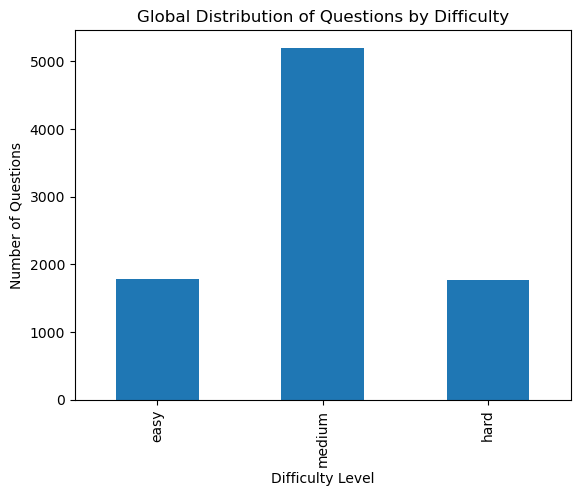

Sample question from each difficulty level:

--- EASY ---
Question ID: train_5457
Question Text: <｜User｜>14 less than two times the number of koi fish in the pond is 64. How many koi fish will you find in the pond?<｜Assistant｜>

--- HARD ---
Question ID: train_5417
Question Text: <｜User｜>Mary tried to improve her health by changing her diet, but her weight bounced like a yo-yo.  At first, she dropped a dozen pounds. Then, she added back twice the weight that she initially lost.  Then, she dropped three times more weight than she initially had lost.  But finally, she gained back half of a dozen pounds.  If she weighed 99 pounds at the start of her change in diet, what was her final weight, in pounds?<｜Assistant｜>

--- MEDIUM ---
Question ID: train_1893
Question Text: <｜User｜>James gets paid $0.50/mile to drive a truck carrying hazardous waste. He has to pay $4.00/gallon for gas and his truck gets 20 miles per gallon. How much profit does he make from a 600 mile trip?<｜Assistant｜>



In [5]:
import os
import glob
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# Path to processed files
input_dir = "data/gsm8k_results_with_difficulty"

# Collect all processed CSVs
all_files = glob.glob(os.path.join(input_dir, "*_with_difficulty.csv"))

# Read and concatenate all dataframes
dfs = []
for file in tqdm(all_files, desc="Loading files"):
    df = pd.read_csv(file)
    dfs.append(df)
combined_df = pd.concat(dfs, ignore_index=True)

# Compute global distribution
dist = combined_df['difficulty'].value_counts().reindex(['easy', 'medium', 'hard']).fillna(0)

# Plot distribution
plt.figure()
dist.plot(kind='bar')
plt.title("Global Distribution of Questions by Difficulty")
plt.xlabel("Difficulty Level")
plt.ylabel("Number of Questions")
plt.show()

# Sample one question from each category
samples = combined_df.groupby('difficulty').apply(lambda g: g.sample(1)).reset_index(drop=True)

print("Sample question from each difficulty level:\n")
for _, row in samples.iterrows():
    print(f"--- {row['difficulty'].upper()} ---")
    print(f"Question ID: {row['question_id']}")
    print(f"Question Text: {row['question_text']}\n")


In [6]:
import os
import glob
import ast
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

input_dir = "data/gsm8k_results_with_difficulty"
files = glob.glob(os.path.join(input_dir, "*_with_difficulty.csv"))

# long-form DataFrame: one row per question per bin
records = []
records_flat = []
bins = [16 * i for i in range(1, 17)]  # [16, 32, …, 256]

for path in files:
    df = pd.read_csv(path)
    df_pred_difficulty = pd.read_csv(path.replace("_with_difficulty.csv", "_difficulty_pred_zeroshot.csv").replace("gsm8k_results_with_difficulty", "gsm8k_difficulty_pred_zeroshot"))
    df = df.merge(df_pred_difficulty[["question_id", "difficulty_pred_zeroshot"]], on='question_id', how='left')
    # make sure any missing values in df are default filled to medium
    df["difficulty_pred_zeroshot"] = df["difficulty_pred_zeroshot"].fillna("medium")
    for i, row in df.iterrows():
        vec = ast.literal_eval(row["early_stop_correct_proportions"])
        records_flat.append({
            "difficulty": row["difficulty"],
            "difficulty_pred_model": row["model_predicted_difficulty"],
            "proportion": vec,
            "question_id": row["question_id"],
            "difficulty_pred_zeroshot": row["difficulty_pred_zeroshot"],
            "split": "test" if "test" in path else "train",
        })
        
        for tok, prob in zip(bins, vec):
            records.append({
                "difficulty": row["difficulty"],
                "difficulty_pred_zeroshot": row["difficulty_pred_zeroshot"],
                "difficulty_pred_model": row["model_predicted_difficulty"],
                "tokens": tok,
                "proportion": prob,
                "split": "test" if "test" in path else "train",
            })

long_df = pd.DataFrame(records)
flat_df = pd.DataFrame(records_flat)
#print(long_df["split"].unique())

# 3) Plot with Seaborn
plt.figure(figsize=(8, 5))
sns.lineplot(
    data=long_df,
    x="tokens",
    y="proportion",
    hue="difficulty",
)
plt.title("Early-Stopping Correct Prob by Difficulty")
plt.xlabel("Number of Tokens")
plt.ylabel("Prob")
plt.xticks(bins, rotation=45)
plt.tight_layout()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'data/gsm8k_difficulty_pred_zeroshot/gsm8k_Y_train_21_difficulty_pred_zeroshot.csv'

In [183]:
import os
import glob
import ast
import numpy as np
import pandas as pd

# — CONFIG —
input_dir = "data/gsm8k_results_with_difficulty"
pattern   = "*_with_difficulty.csv"

# token bins: 16, 32, …, 256
bins = [16 * i for i in range(1, 17)]

# collect vectors by (split, difficulty)
grouped = {}  # keys = (split, difficulty), value = list of vectors
for path in glob.glob(os.path.join(input_dir, pattern)):
    df = pd.read_csv(path)
    for _, row in df.iterrows():
        split = row["split"]   # e.g. "train" or "test"
        diff  = row["difficulty"]
        vec   = ast.literal_eval(row["early_stop_correct_proportions"])
        grouped.setdefault((split, diff), []).append(vec)

# compute & print stats
for split in sorted({s for s, _ in grouped}):
    print(f"\n=== SPLIT: {split.upper()} ===")
    for diff in ["easy", "medium", "hard"]:
        vecs = grouped.get((split, diff), [])
        arr  = np.array(vecs)
        print(f"\n--- {diff.upper()} (n={arr.shape[0]}) ---")
        if arr.size == 0:
            print("  No data for this category.")
            continue

        mean_vec = arr.mean(axis=0)
        std_vec  = arr.std(axis=0)
        p25_vec  = np.percentile(arr, 25, axis=0)
        p75_vec  = np.percentile(arr, 75, axis=0)

        stats_df = pd.DataFrame({
            "tokens":       bins,
            "mean":         mean_vec,
            "std_dev":      std_vec,
            "25th_pctile":  p25_vec,
            "75th_pctile":  p75_vec
        })

        print(stats_df.to_string(index=False))



=== SPLIT: TEST ===

--- EASY (n=271) ---
 tokens     mean  std_dev  25th_pctile  75th_pctile
     16 0.240554 0.319319        0.000        0.430
     32 0.226974 0.294851        0.000        0.375
     48 0.272399 0.288748        0.020        0.455
     64 0.394133 0.303361        0.120        0.675
     80 0.500812 0.291988        0.260        0.770
     96 0.602177 0.267874        0.420        0.830
    112 0.665720 0.237740        0.560        0.850
    128 0.720627 0.202963        0.635        0.870
    144 0.759188 0.172520        0.680        0.880
    160 0.790332 0.145608        0.740        0.890
    176 0.804649 0.122871        0.750        0.890
    192 0.817638 0.102947        0.770        0.890
    208 0.839299 0.083648        0.795        0.900
    224 0.851513 0.068685        0.810        0.900
    240 0.866421 0.059296        0.830        0.910
    256 0.884576 0.046387        0.850        0.920

--- MEDIUM (n=760) ---
 tokens     mean  std_dev  25th_pctile  75th_pcti

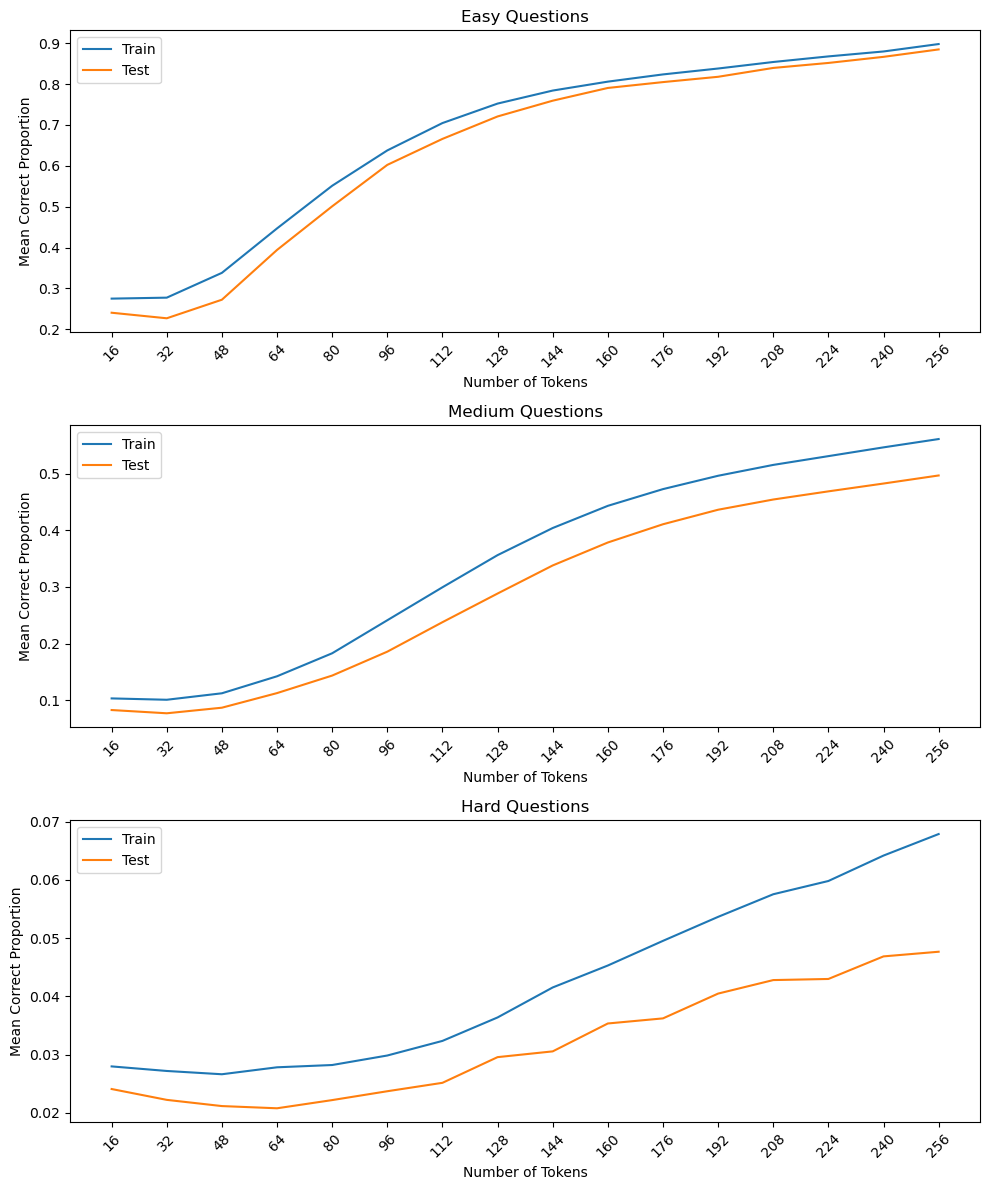

In [2]:
import os
import glob
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Configuration
input_dir = "data/gsm8k_results_with_difficulty"
pattern   = "*_with_difficulty.csv"

# Token bins: 16, 32, …, 256
bins = [16 * i for i in range(1, 17)]

# Prepare storage: data[difficulty][split] = list of vectors
difficulties = ["easy", "medium", "hard"]
splits       = ["train", "test"]
data = {d: {s: [] for s in splits} for d in difficulties}

# Load and group
for path in glob.glob(os.path.join(input_dir, pattern)):
    df = pd.read_csv(path)
    for _, row in df.iterrows():
        # determine split key
        sp = row["split"]
        if sp.startswith("train"):
            split_key = "train"
        elif sp.startswith("test"):
            split_key = "test"
        else:
            continue
        diff = row["difficulty"]
        if diff in data:
            vec = ast.literal_eval(row["early_stop_correct_proportions"])
            data[diff][split_key].append(vec)

# Plot train vs test mean curve for each difficulty
plt.figure(figsize=(10, 12))
for i, diff in enumerate(difficulties, start=1):
    arr_train = np.array(data[diff]["train"])
    arr_test  = np.array(data[diff]["test"])
    mean_train = arr_train.mean(axis=0)
    mean_test  = arr_test.mean(axis=0)

    ax = plt.subplot(3, 1, i)
    ax.plot(bins, mean_train, label="Train")
    ax.plot(bins, mean_test,  label="Test")
    ax.set_title(f"{diff.title()} Questions")
    ax.set_xlabel("Number of Tokens")
    ax.set_ylabel("Mean Correct Proportion")
    ax.legend()
    ax.set_xticks(bins)
    ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()


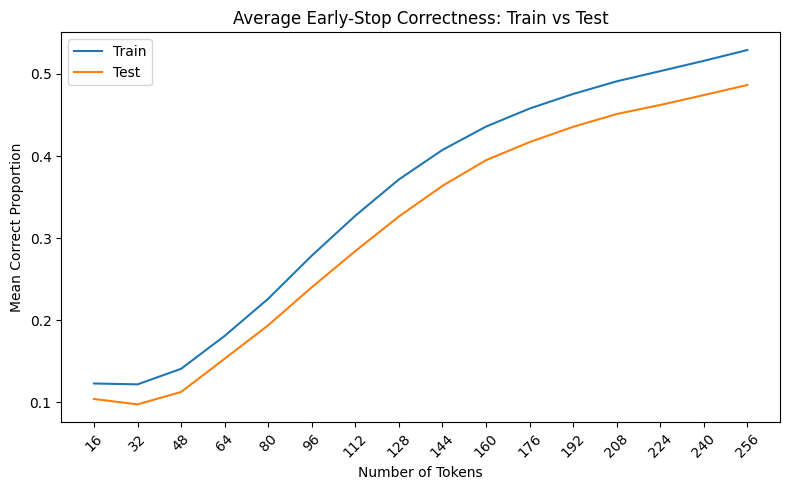

In [185]:
import os
import glob
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Configuration
input_dir = "data/gsm8k_results_with_difficulty"
pattern = "*_with_difficulty.csv"

# Token bins: 16, 32, ..., 256
bins = [16 * i for i in range(1, 17)]

# Collect early-stop vectors by split
data = {'train': [], 'test': []}
for path in glob.glob(os.path.join(input_dir, pattern)):
    df = pd.read_csv(path)
    for _, row in df.iterrows():
        # Adjust this if your split column has suffixes
        split = row['split']  
        if split.startswith('train'):
            key = 'train'
        elif split.startswith('test'):
            key = 'test'
        else:
            continue
        vec = ast.literal_eval(row["early_stop_correct_proportions"])
        data[key].append(vec)

# Convert to numpy arrays
arr_train = np.array(data['train'])
arr_test  = np.array(data['test'])

# Compute mean vectors
mean_train = arr_train.mean(axis=0)
mean_test  = arr_test.mean(axis=0)

# Plot comparison
plt.figure(figsize=(8, 5))
plt.plot(bins, mean_train, label='Train')
plt.plot(bins, mean_test,  label='Test')
plt.title('Average Early-Stop Correctness: Train vs Test')
plt.xlabel('Number of Tokens')
plt.ylabel('Mean Correct Proportion')
plt.legend()
plt.xticks(bins, rotation=45)
plt.tight_layout()
plt.show()


# Get oracle results

In [4]:
long_df.head()

NameError: name 'long_df' is not defined

In [187]:
easy_vec = long_df.query("split == 'train'").query('difficulty == "easy"').groupby("tokens").mean().values.squeeze()
medium_vec = long_df.query("split == 'train'").query('difficulty == "medium"').groupby("tokens").mean().values.squeeze()
hard_vec = long_df.query("split == 'train'").query('difficulty == "hard"').groupby("tokens").mean().values.squeeze()

In [188]:
# Define p1, p2, p3 to be the proportion of questions that are easy vs medium vs hard
p1 = (long_df.query("split == 'train'")["difficulty"] == "easy").mean()
p2 = (long_df.query("split == 'train'")["difficulty"] == "medium").mean()
p3 = (long_df.query("split == 'train'")["difficulty"] == "hard").mean()
print(p1, p2, p3)

0.20214765100671142 0.5955704697986577 0.20228187919463086


In [3]:
# Define a function get_per_category_budget(b) that takes in a token budget b
# and returns three numbers b1, b2, b3 subject to constraint p1*b1+p2*b2+p3*b3 <= b
# that maximizes p1*easy_vec[b1//16 - 1]+p2*medium_vec[b2//16 - 1] + p3*hard_vec[b3//16 - 1]
def get_per_category_budget(b, split="train", col="difficulty"):
    """
    Find optimal token budgets b1, b2, b3 for easy, medium, and hard questions
    that maximize weighted probability subject to p1*b1 + p2*b2 + p3*b3 <= b.
    
    Args:
        b: Total token budget
        
    Returns:
        tuple: (b1, b2, b3) optimal token budgets for each category
    """
    # Token budgets must be multiples of 16 and at most 256
    possible_budgets = list(range(16, 257, 16))
    
    p1 = (long_df.query(f"split == '{split}'")[col] == "easy").mean()
    p2 = (long_df.query(f"split == '{split}'")[col] == "medium").mean()
    p3 = (long_df.query(f"split == '{split}'")[col] == "hard").mean()
    print(b, split, np.round(p1, 3), np.round(p2, 3), np.round(p3, 3))
    # Initialize best values
    best_score = -float('inf')
    best_b1 = 16
    best_b2 = 16
    best_b3 = 16
    
    # Try all valid combinations
    for b1 in possible_budgets:
        for b2 in possible_budgets:
            for b3 in possible_budgets:
                # Check budget constraint
                if p1*b1 + p2*b2 + p3*b3 <= b:
                    # Calculate score for this combination
                    # Note: arrays are 0-indexed but budgets are 1-indexed in terms of chunks
                    score = (p1 * easy_vec[b1//16 - 1] + 
                           p2 * medium_vec[b2//16 - 1] + 
                           p3 * hard_vec[b3//16 - 1])
                    
                    # Update best if this score is better
                    if score > best_score:
                        best_score = score
                        best_b1 = b1
                        best_b2 = b2
                        best_b3 = b3
    
    return best_b1, best_b2, best_b3, best_score

budgets = [get_per_category_budget(b) for b in range(16, 257, 16)]


NameError: name 'long_df' is not defined

In [190]:
flat_df.head()

,difficulty,difficulty_pred_model,proportion,question_id,difficulty_pred_zeroshot,split
0,medium,medium,"[0.04, 0.12000000000000002, 0.04, 0.0300000000...",test_0,medium,test
1,easy,medium,"[0.63, 0.63, 0.83, 0.88, 0.86, 0.94, 0.94, 0.9...",test_1,easy,test
2,hard,medium,"[0.02, 0.0, 0.02, 0.01, 0.0, 0.01, 0.01, 0.02,...",test_2,medium,test
3,hard,medium,"[0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",test_3,hard,test
4,medium,medium,"[0.4, 0.25, 0.09, 0.03, 0.05, 0.36, 0.55, 0.69...",test_4,medium,test


In [191]:

def get_accuracy(df_adaptive, b, split="train", col="difficulty"):
    '''
    Takes a dataframe df_adaptive with columns 'early_stop_correct_proportions', 'difficulty_hat', and 'difficulty'
    For the given budget, computes b1, b2, b3 based on the train set oracle
    Then, computes the accuracy across all questions in df_adaptive based on the accuracy
    that each individual question would have had if it were allocated the given budget determined by
    its predicted difficulty and the b1, b2, b3 budget allocated to questions of each difficulty.
    '''
    df_adaptive = df_adaptive.copy().query(f"split == '{split}'")
    b1, b2, b3, _ = get_per_category_budget(b)
    df_adaptive['budget'] = df_adaptive[col].apply(lambda x: b1 if x == 'easy' else (b2 if x == 'medium' else b3))
    df_adaptive['accuracy'] = df_adaptive.apply(lambda x: x['proportion'][x['budget']//16 - 1], axis=1)
    return df_adaptive['accuracy'].mean()

adaptive_accuracies_train_zeroshot = [get_accuracy(flat_df, b, split="train", col="difficulty_pred_zeroshot") for b in range(16, 257, 16)]
adaptive_accuracies_test_zeroshot = [get_accuracy(flat_df, b, split="test", col="difficulty_pred_zeroshot") for b in range(16, 257, 16)]
adaptive_accuracies_train = [get_accuracy(flat_df, b, split="train", col="difficulty") for b in range(16, 257, 16)]
adaptive_accuracies_test = [get_accuracy(flat_df, b, split="test", col="difficulty") for b in range(16, 257, 16)]

    

16 train 0.202 0.596 0.202
32 train 0.202 0.596 0.202
48 train 0.202 0.596 0.202
64 train 0.202 0.596 0.202
80 train 0.202 0.596 0.202
96 train 0.202 0.596 0.202
112 train 0.202 0.596 0.202
128 train 0.202 0.596 0.202
144 train 0.202 0.596 0.202
160 train 0.202 0.596 0.202
176 train 0.202 0.596 0.202
192 train 0.202 0.596 0.202
208 train 0.202 0.596 0.202
224 train 0.202 0.596 0.202
240 train 0.202 0.596 0.202
256 train 0.202 0.596 0.202
16 train 0.202 0.596 0.202
32 train 0.202 0.596 0.202
48 train 0.202 0.596 0.202
64 train 0.202 0.596 0.202
80 train 0.202 0.596 0.202
96 train 0.202 0.596 0.202
112 train 0.202 0.596 0.202
128 train 0.202 0.596 0.202
144 train 0.202 0.596 0.202
160 train 0.202 0.596 0.202
176 train 0.202 0.596 0.202
192 train 0.202 0.596 0.202
208 train 0.202 0.596 0.202
224 train 0.202 0.596 0.202
240 train 0.202 0.596 0.202
256 train 0.202 0.596 0.202
16 train 0.202 0.596 0.202
32 train 0.202 0.596 0.202
48 train 0.202 0.596 0.202
64 train 0.202 0.596 0.202
80 train

In [192]:
def get_nonadaptive_accuracy(df_adaptive, b, split="train"):
    df_adaptive = df_adaptive.copy().query(f"split == '{split}'")
    df_adaptive['accuracy'] = df_adaptive.apply(lambda x: x['proportion'][b//16 - 1], axis=1)
    return df_adaptive['accuracy'].mean()
nonadaptive_scores_train = [get_nonadaptive_accuracy(flat_df, b, split="train") for b in range(16, 257, 16)]
nonadaptive_scores_test = [get_nonadaptive_accuracy(flat_df, b, split="test") for b in range(16, 257, 16)]


In [195]:
flat_df.head()

,difficulty,difficulty_pred_model,proportion,question_id,difficulty_pred_zeroshot,split
0,medium,medium,"[0.04, 0.12000000000000002, 0.04, 0.0300000000...",test_0,medium,test
1,easy,medium,"[0.63, 0.63, 0.83, 0.88, 0.86, 0.94, 0.94, 0.9...",test_1,easy,test
2,hard,medium,"[0.02, 0.0, 0.02, 0.01, 0.0, 0.01, 0.01, 0.02,...",test_2,medium,test
3,hard,medium,"[0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",test_3,hard,test
4,medium,medium,"[0.4, 0.25, 0.09, 0.03, 0.05, 0.36, 0.55, 0.69...",test_4,medium,test


In [199]:
from itertools import product
df_res = pd.DataFrame() # TODO: should have one row per (question_id, b) pair!!!
# Create all combinations of budgets and question IDs using product
budgets = range(16, 257, 16)
question_ids = flat_df["question_id"].tolist()
data = [{"question_id": qid, "budget": b} for b, qid in product(budgets, question_ids)]
df_res = pd.DataFrame(data)
df_res = df_res.merge(flat_df[['question_id', 'proportion', 'difficulty', 'difficulty_pred_zeroshot', 'difficulty_pred_model', 'split']], on="question_id", how="left")
print(df_res.shape)
df_res["accuracy_nonadaptive"] = df_res.apply(lambda x: x['proportion'][x['budget']//16-1], axis=1)
# TODO: create sns.lineplot to show oracle vs our method results
def get_accuracy_res(col="difficulty"):
    '''
    Takes a dataframe df_adaptive with columns 'early_stop_correct_proportions', 'difficulty_hat', and 'difficulty'
    For the given budget, computes b1, b2, b3 based on the train set oracle
    Then, computes the accuracy across all questions in df_adaptive based on the accuracy
    that each individual question would have had if it were allocated the given budget determined by
    its predicted difficulty and the b1, b2, b3 budget allocated to questions of each difficulty.
    '''
    df_res[f'budget_{col}'] = None
    df_res[f'accuracy_{col}'] = None
    for b in range(16, 257, 16):
        for split in ["train", "test"]:
            # TODO: fix this function so it gives correct
            # non hallucinated RESULTS
            b1, b2, b3, _ = get_per_category_budget(b, split, col)
            #print(split, b, b1, b2, b3)
            df_res[f'budget_{col}'].loc[(df_res['budget'] == b) & (df_res['split'] == split)] = df_res[col].loc[(df_res['budget'] == b) & (df_res['split'] == split)].apply(lambda x: b1 if x == 'easy' else (b2 if x == 'medium' else b3))
            df_res[f'accuracy_{col}'].loc[(df_res['budget'] == b) & (df_res['split'] == split)] = df_res.loc[(df_res['budget'] == b) & (df_res['split'] == split)].apply(lambda x: x['proportion'][x[f'budget_{col}']//16 - 1], axis=1)

get_accuracy_res(col="difficulty_pred_zeroshot")
get_accuracy_res(col="difficulty_pred_model")
get_accuracy_res(col="difficulty")
    

(139904, 7)
16 train 0.626 0.353 0.021
16 test 0.599 0.382 0.019


c:\Users\Katrina\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


32 train 0.626 0.353 0.021
32 test 0.599 0.382 0.019
48 train 0.626 0.353 0.021
48 test 0.599 0.382 0.019
64 train 0.626 0.353 0.021
64 test 0.599 0.382 0.019
80 train 0.626 0.353 0.021
80 test 0.599 0.382 0.019
96 train 0.626 0.353 0.021
96 test 0.599 0.382 0.019
112 train 0.626 0.353 0.021
112 test 0.599 0.382 0.019
128 train 0.626 0.353 0.021
128 test 0.599 0.382 0.019
144 train 0.626 0.353 0.021
144 test 0.599 0.382 0.019
160 train 0.626 0.353 0.021
160 test 0.599 0.382 0.019
176 train 0.626 0.353 0.021
176 test 0.599 0.382 0.019
192 train 0.626 0.353 0.021
192 test 0.599 0.382 0.019
208 train 0.626 0.353 0.021
208 test 0.599 0.382 0.019
224 train 0.626 0.353 0.021
224 test 0.599 0.382 0.019
240 train 0.626 0.353 0.021
240 test 0.599 0.382 0.019
256 train 0.626 0.353 0.021
256 test 0.599 0.382 0.019
16 train 0.248 0.645 0.107
16 test 0.201 0.674 0.125
32 train 0.248 0.645 0.107
32 test 0.201 0.674 0.125
48 train 0.248 0.645 0.107
48 test 0.201 0.674 0.125
64 train 0.248 0.645 0.107

In [200]:
df_res.head()

,question_id,budget,proportion,difficulty,difficulty_pred_zeroshot,difficulty_pred_model,split,accuracy_nonadaptive,budget_difficulty_pred_zeroshot,accuracy_difficulty_pred_zeroshot,budget_difficulty_pred_model,accuracy_difficulty_pred_model,budget_difficulty,accuracy_difficulty
0,test_0,16,"[0.04, 0.12000000000000002, 0.04, 0.0300000000...",medium,medium,medium,test,0.04,16,0.04,16,0.04,16,0.04
1,test_1,16,"[0.63, 0.63, 0.83, 0.88, 0.86, 0.94, 0.94, 0.9...",easy,easy,medium,test,0.63,16,0.63,16,0.63,16,0.63
2,test_2,16,"[0.02, 0.0, 0.02, 0.01, 0.0, 0.01, 0.01, 0.02,...",hard,medium,medium,test,0.02,16,0.02,16,0.02,16,0.02
3,test_3,16,"[0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",hard,hard,medium,test,0.01,16,0.01,16,0.01,16,0.01
4,test_4,16,"[0.4, 0.25, 0.09, 0.03, 0.05, 0.36, 0.55, 0.69...",medium,medium,medium,test,0.40,16,0.4,16,0.4,16,0.4


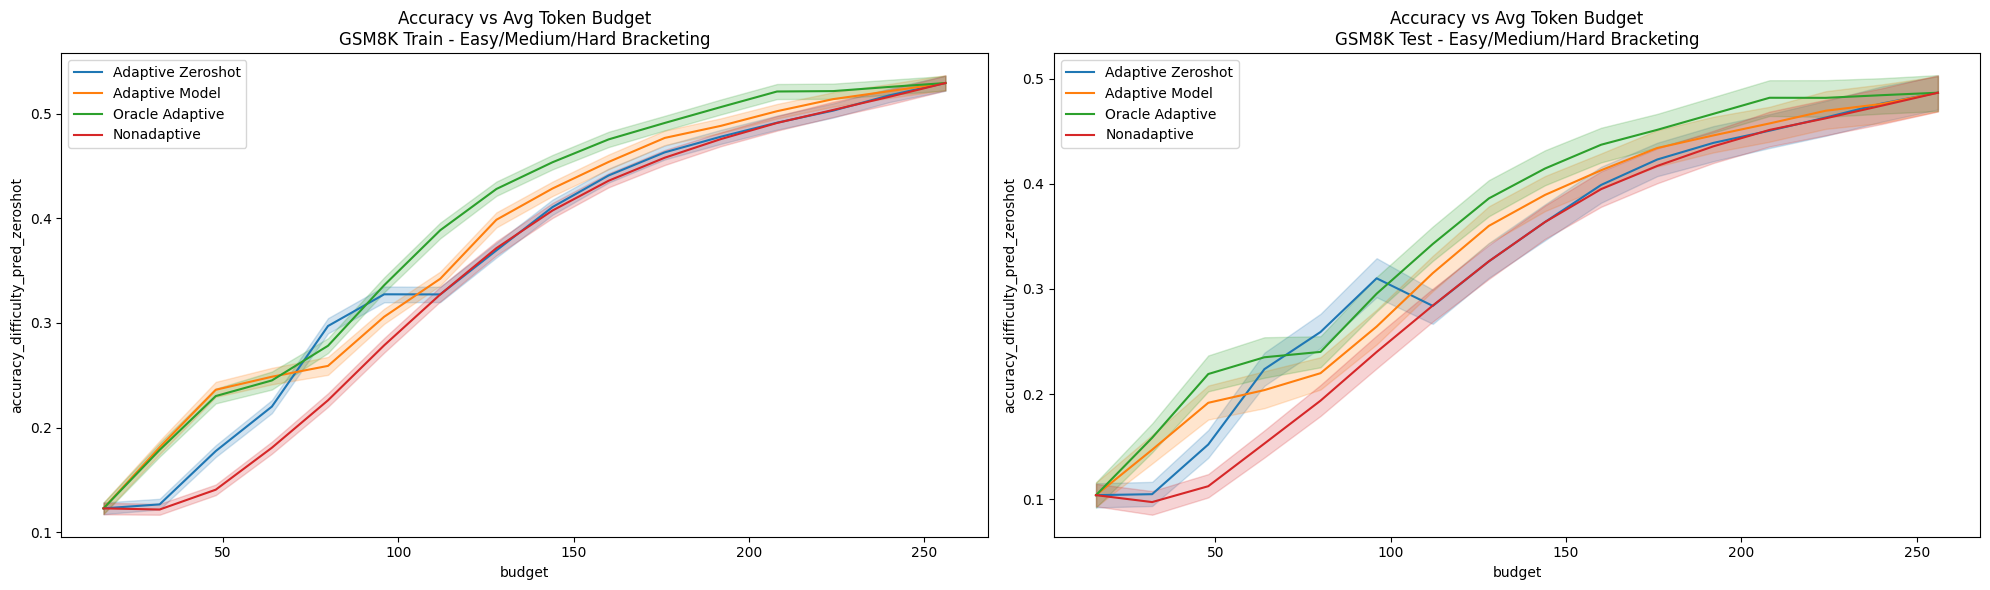

In [208]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Train plot
sns.lineplot(data=df_res.query("split == 'train'"), x="budget", y="accuracy_difficulty_pred_zeroshot", label='Adaptive Zeroshot', ax=ax1)
sns.lineplot(data=df_res.query("split == 'train'"), x="budget", y="accuracy_difficulty_pred_model", label='Adaptive Model', ax=ax1)
sns.lineplot(data=df_res.query("split == 'train'"), x="budget", y="accuracy_difficulty", label='Oracle Adaptive', ax=ax1)
sns.lineplot(data=df_res.query("split == 'train'"), x="budget", y="accuracy_nonadaptive", label='Nonadaptive', ax=ax1)
ax1.set_title('Accuracy vs Avg Token Budget\nGSM8K Train - Easy/Medium/Hard Bracketing')
ax1.legend()

# Test plot
sns.lineplot(data=df_res.query("split == 'test'"), x="budget", y="accuracy_difficulty_pred_zeroshot", label='Adaptive Zeroshot', ax=ax2)
sns.lineplot(data=df_res.query("split == 'test'"), x="budget", y="accuracy_difficulty_pred_model", label='Adaptive Model', ax=ax2)
sns.lineplot(data=df_res.query("split == 'test'"), x="budget", y="accuracy_difficulty", label='Oracle Adaptive', ax=ax2)
sns.lineplot(data=df_res.query("split == 'test'"), x="budget", y="accuracy_nonadaptive", label='Nonadaptive', ax=ax2)
ax2.set_title('Accuracy vs Avg Token Budget\nGSM8K Test - Easy/Medium/Hard Bracketing')
ax2.legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [223]:
df_res.to_csv("data/plot_difficulty.csv")

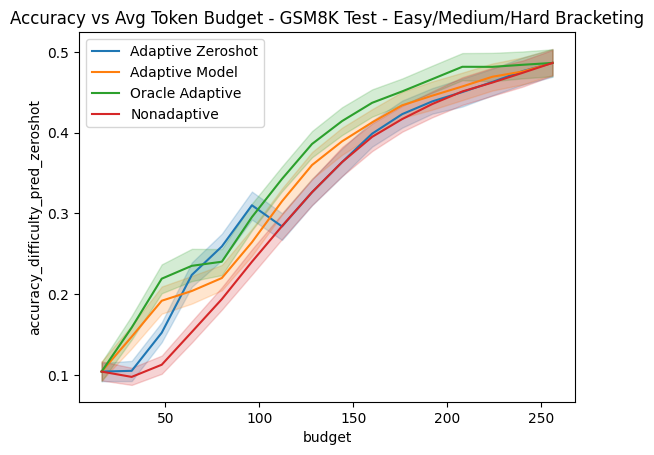

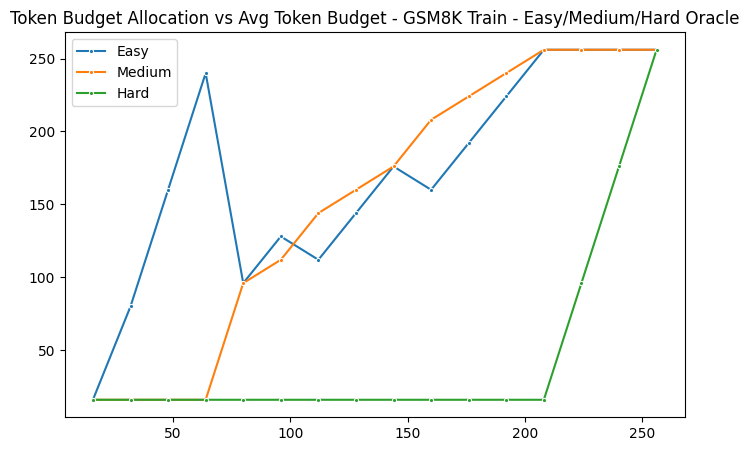

In [111]:
# For each b on the x-axis, plot the b1, b3, b3 as 3 separate plots over time
plt.figure(figsize=(8, 5))
sns.lineplot(x=bins, y=[b[0] for b in budgets], label='Easy', marker='.')
sns.lineplot(x=bins, y=[b[1] for b in budgets], label='Medium', marker='.') 
sns.lineplot(x=bins, y=[b[2] for b in budgets], label='Hard', marker='.')
plt.title('Token Budget Allocation vs Avg Token Budget - GSM8K Train - Easy/Medium/Hard Oracle')
plt.legend()
plt.show()


In [217]:
(flat_df.query("split == 'test'")["difficulty"]==flat_df.query("split == 'test'")["difficulty_pred_zeroshot"]).mean()

0.41576506955177744

In [218]:
(flat_df.query("split == 'test'")["difficulty"]==flat_df.query("split == 'test'")["difficulty_pred_model"]).mean()

0.6630602782071098

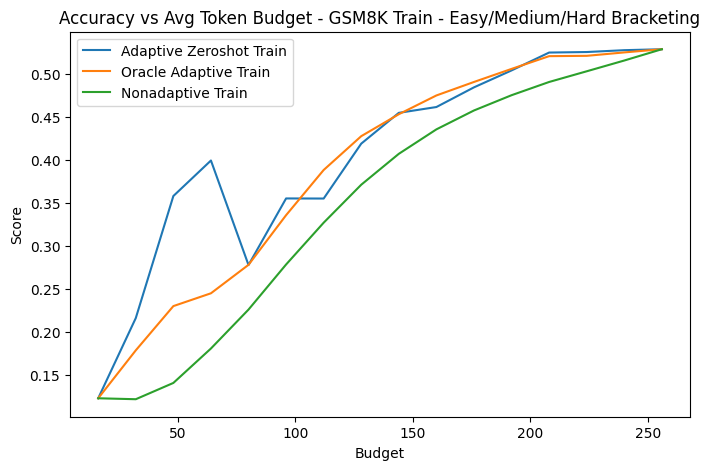

In [ ]:
# For lineplot, need columns for budget b, nonadaptive reward, oracle reward, zeroshot reward, split, question_id
plt.figure(figsize=(8, 5))
plt.plot(bins, adaptive_accuracies_train_zeroshot, label='Adaptive Zeroshot Train')
plt.plot(bins, adaptive_accuracies_train, label='Oracle Adaptive Train')
plt.plot(bins, nonadaptive_scores_train, label='Nonadaptive Train')
plt.title('Accuracy vs Avg Token Budget - GSM8K Train - Easy/Medium/Hard Bracketing')
plt.legend()
plt.xlabel('Budget')
plt.ylabel('Score')
plt.legend()
plt.show()

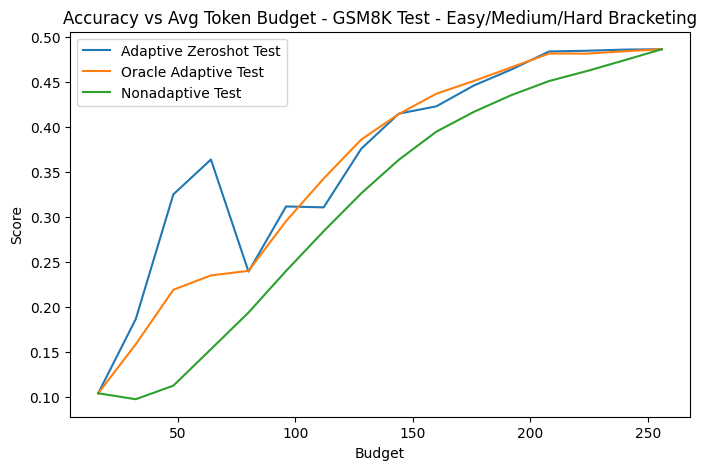

In [114]:
plt.figure(figsize=(8, 5))
plt.plot(bins, adaptive_accuracies_test_zeroshot, label='Adaptive Zeroshot Test')
plt.plot(bins, adaptive_accuracies_test, label='Oracle Adaptive Test')
plt.plot(bins, nonadaptive_scores_test, label='Nonadaptive Test')
plt.title('Accuracy vs Avg Token Budget - GSM8K Test - Easy/Medium/Hard Bracketing')
plt.legend()
plt.xlabel('Budget')
plt.ylabel('Score')
plt.legend()
plt.show()

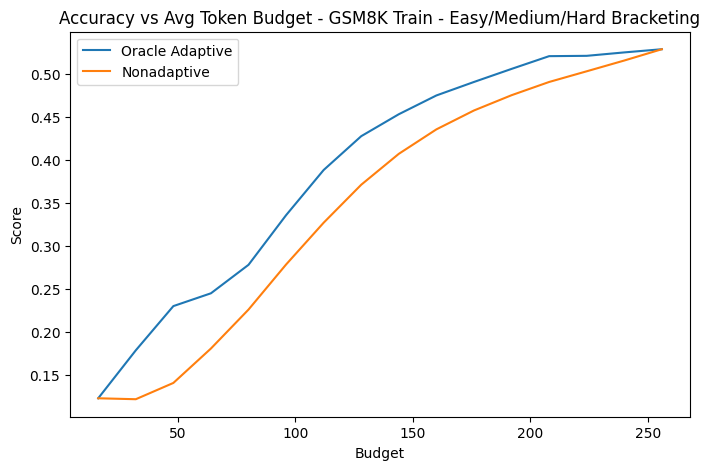

In [115]:
scores = [b[3] for b in budgets]

plt.figure(figsize=(8, 5))
plt.plot(bins, scores, label='Oracle Adaptive')
plt.plot(bins, nonadaptive_scores, label='Nonadaptive')
plt.title('Accuracy vs Avg Token Budget - GSM8K Train - Easy/Medium/Hard Bracketing')
plt.legend()
plt.xlabel('Budget')
plt.ylabel('Score')
plt.legend()
plt.show()


### Test accuracy

In [121]:
(flat_df["difficulty"]==flat_df["difficulty_pred_zeroshot"]).mean()

0.3974153705397987

In [124]:
flat_df["difficulty"].value_counts()

medium    5197
easy      1777
hard      1770
Name: difficulty, dtype: int64

In [220]:
flat_df.query("split == 'train'")["difficulty"].value_counts()

medium    4437
hard      1507
easy      1506
Name: difficulty, dtype: int64

In [221]:
flat_df.query("split == 'test'")["difficulty"].value_counts()

medium    760
easy      271
hard      263
Name: difficulty, dtype: int64

In [125]:
flat_df["difficulty_pred_zeroshot"].value_counts()


easy      5439
medium    3124
hard       181
Name: difficulty_pred_zeroshot, dtype: int64

In [133]:
import numpy as np
np.round(confusion_matrix(flat_df["difficulty"], flat_df["difficulty_pred_zeroshot"], normalize="true"), 3)

array([[0.876, 0.006, 0.119],
       [0.315, 0.062, 0.623],
       [0.64 , 0.012, 0.348]])

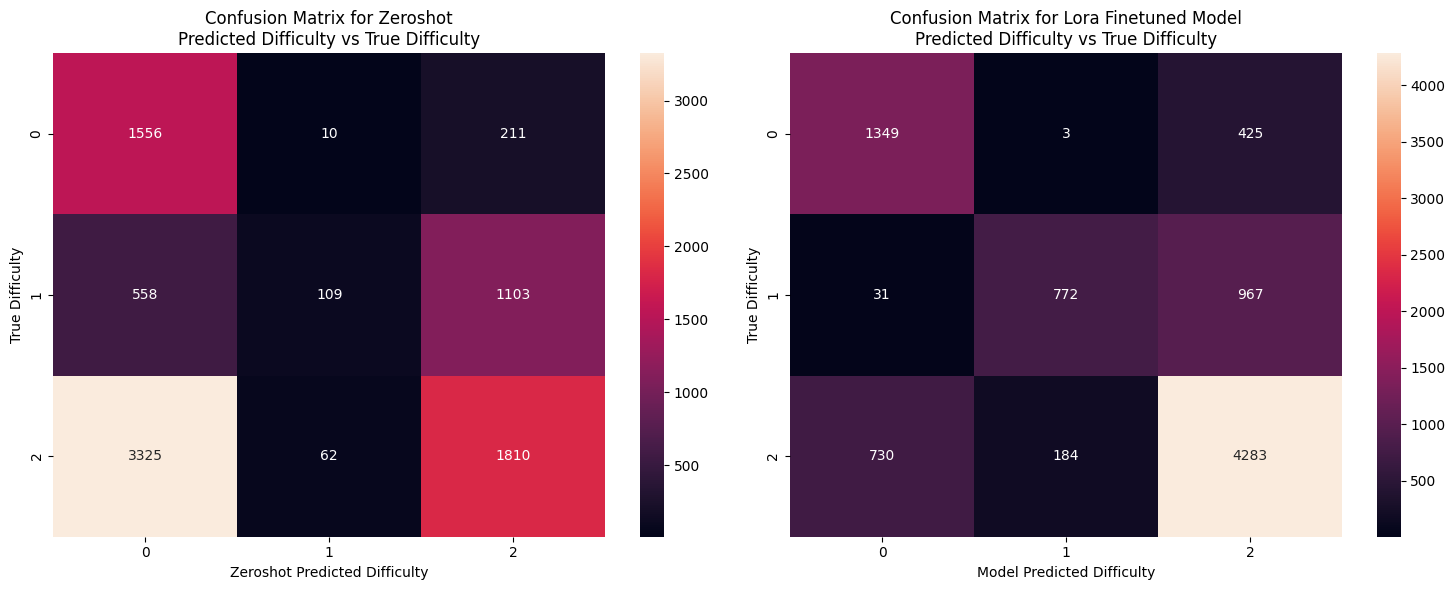

In [207]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# First confusion matrix
sns.heatmap(confusion_matrix(flat_df["difficulty"], flat_df["difficulty_pred_zeroshot"]), 
            annot=True, fmt='d', ax=ax1)
ax1.set_xlabel('Zeroshot Predicted Difficulty')
ax1.set_ylabel('True Difficulty')
ax1.set_title('Confusion Matrix for Zeroshot\nPredicted Difficulty vs True Difficulty')

# Second confusion matrix
sns.heatmap(confusion_matrix(flat_df["difficulty"], flat_df["difficulty_pred_model"]), 
            annot=True, fmt='d', ax=ax2)
ax2.set_xlabel('Model Predicted Difficulty')
ax2.set_ylabel('True Difficulty')
ax2.set_title('Confusion Matrix for Lora Finetuned Model\nPredicted Difficulty vs True Difficulty')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

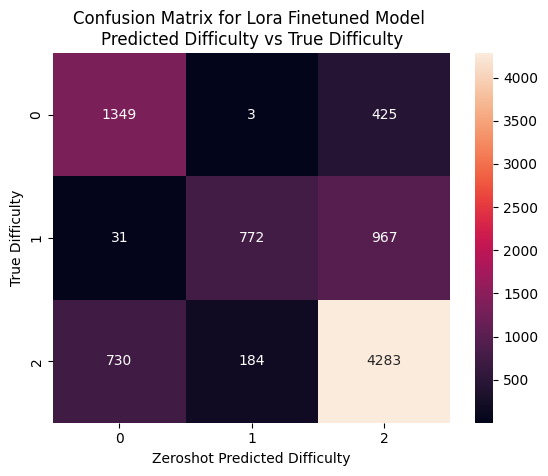